In [1]:
cols = {
    "loan_id": 1,
    "orig_interest_rate": 7,
    "orig_upb": 9,
    "orig_loan_term": 12,
    "orig_date": 13,
    # "orig_ltv": 19,
    # "orig_dti": 22,
    # "orig_credit_score": 23,
    "amortization_type": 34,
    "interest_only": 36,
    "zero_balance_code": 43,
    "zero_balance_date": 44,
    "upb_at_removal": 45,
    "foreclosure_costs": 53,
    "preservation_and_repair_costs": 54,
    "asset_recovery_costs": 55,
    "misc_holding_costs": 56,
    "holding_taxes_costs": 57,
    "net_sales_proceeds": 58,
    "credit_enhancement_proceeds": 59,
    "repurchase_make_whole_proceeds": 60,
    "other_foreclosure_proceeds": 61
}

col_indexes = cols.values()

In [ ]:
def get_months(date_num: float) -> int:
    date_str = str(int(date_num))
    month = date_str[:-4]
    year = date_str[-4:]

    return int(month) + 12 * int(year)

In [ ]:
import pandas as pd
import numpy as np

data_2020Q1 = pd.read_csv(
    "data/2020Q1.csv",
    delimiter="|",
    header=None,
    usecols=col_indexes
)[col_indexes]
data_2020Q1.columns = cols.keys()

data_2020Q1 = data_2020Q1[
    (data_2020Q1["amortization_type"] == "FRM") &
    (data_2020Q1["interest_only"] == "N") &
    data_2020Q1["zero_balance_code"].notna()
].drop(
    columns=["amortization_type", "interest_only"]
).set_index("loan_id")

data_2020Q1["active_months"] = \
    (data_2020Q1["zero_balance_date"].apply(get_months) - data_2020Q1["orig_date"].apply(get_months))
data_2020Q1.drop(
    columns=["orig_date", "zero_balance_date"],
    inplace=True
)

data_2020Q1

,orig_interest_rate,orig_upb,orig_loan_term,zero_balance_code,upb_at_removal,foreclosure_costs,preservation_and_repair_costs,asset_recovery_costs,misc_holding_costs,holding_taxes_costs,net_sales_proceeds,credit_enhancement_proceeds,repurchase_make_whole_proceeds,other_foreclosure_proceeds,active_months
loan_id,,,,,,,,,,,,,,,
98836742,3.375,308000.0,180,1.0,295534.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
98836743,3.625,207000.0,240,1.0,202842.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
98836744,3.625,215000.0,240,1.0,200243.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
98836745,4.000,319000.0,360,1.0,314314.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
98836746,4.125,362000.0,360,1.0,351264.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99520478,3.625,252000.0,360,1.0,248066.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
99520479,3.625,347000.0,360,1.0,330936.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
99520480,3.250,588000.0,240,1.0,499029.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13


In [5]:
def compute_total_interest(row):
    P = row["orig_upb"]
    r = row["orig_interest_rate"] / 100
    n = row["orig_loan_term"]
    m = row["active_months"]
    
    i = r / 12
    if n <= 0 or m <= 0:
        return 0.0
    M = P * (i * (1 + i)**n) / ((1 + i)**n - 1)
    balance = P
    total_interest = 0.0
    for _ in range(int(m)):
        interest = balance * i
        principal = M - interest
        balance -= principal
        total_interest += interest
    return total_interest

data_2020Q1["interest_paid"] = data_2020Q1.apply(
    compute_total_interest, 
    axis=1
)
data_2020Q1.drop(
    columns=["orig_loan_term", "active_months"],
    inplace=True
)

data_2020Q1

,orig_interest_rate,orig_upb,zero_balance_code,upb_at_removal,foreclosure_costs,preservation_and_repair_costs,asset_recovery_costs,misc_holding_costs,holding_taxes_costs,net_sales_proceeds,credit_enhancement_proceeds,repurchase_make_whole_proceeds,other_foreclosure_proceeds,interest_paid
loan_id,,,,,,,,,,,,,,
98836742,3.375,308000.0,1.0,295534.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9323.340003
98836743,3.625,207000.0,1.0,202842.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5563.355284
98836744,3.625,215000.0,1.0,200243.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15669.953147
98836745,4.000,319000.0,1.0,314314.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10563.773697
98836746,4.125,362000.0,1.0,351264.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26961.797749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99520478,3.625,252000.0,1.0,248066.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9056.858378
99520479,3.625,347000.0,1.0,330936.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30724.608033
99520480,3.250,588000.0,1.0,499029.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20330.692835


In [6]:
default_costs_cols = list(data_2020Q1.columns[data_2020Q1.columns.str.endswith("_costs")])
default_proceeds_cols = list(data_2020Q1.columns[data_2020Q1.columns.str.endswith("_proceeds")])
default_codes = [2, 3, 9, 15, 16]

data_2020Q1.loc[:, "lgd"] = np.nan

defaulted_loan_ids = data_2020Q1["zero_balance_code"].isin(default_codes)

ids = defaulted_loan_ids & data_2020Q1.loc[:, default_costs_cols + default_proceeds_cols].notna().any(axis=1)
data_2020Q1.loc[ids, "lgd"] = (data_2020Q1.loc[ids, "upb_at_removal"] + data_2020Q1.loc[ids, default_costs_cols].sum(axis=1) \
    - data_2020Q1.loc[ids, default_proceeds_cols].sum(axis=1)) / data_2020Q1.loc[ids, "upb_at_removal"]
data_2020Q1.drop(columns=default_costs_cols + default_proceeds_cols, inplace=True)

data_2020Q1

,orig_interest_rate,orig_upb,zero_balance_code,upb_at_removal,interest_paid,lgd
loan_id,,,,,,
98836742,3.375,308000.0,1.0,295534.64,9323.340003,NaN
98836743,3.625,207000.0,1.0,202842.63,5563.355284,NaN
98836744,3.625,215000.0,1.0,200243.50,15669.953147,NaN
98836745,4.000,319000.0,1.0,314314.38,10563.773697,NaN
98836746,4.125,362000.0,1.0,351264.51,26961.797749,NaN
...,...,...,...,...,...,...
99520478,3.625,252000.0,1.0,248066.81,9056.858378,NaN
99520479,3.625,347000.0,1.0,330936.51,30724.608033,NaN
99520480,3.250,588000.0,1.0,499029.62,20330.692835,NaN


In [7]:
notna_lgd_ids = data_2020Q1["lgd"].notna()

for code in default_codes:
    code_ids = data_2020Q1["zero_balance_code"] == code
    ids = code_ids & notna_lgd_ids

    if ids.sum() == 0:
        mean_lgd = 0.6
    else:
        mean_lgd = data_2020Q1.loc[ids, "lgd"].mean()

    data_2020Q1.loc[code_ids & (~notna_lgd_ids), "lgd"] = 1

data_2020Q1

,orig_interest_rate,orig_upb,zero_balance_code,upb_at_removal,interest_paid,lgd
loan_id,,,,,,
98836742,3.375,308000.0,1.0,295534.64,9323.340003,NaN
98836743,3.625,207000.0,1.0,202842.63,5563.355284,NaN
98836744,3.625,215000.0,1.0,200243.50,15669.953147,NaN
98836745,4.000,319000.0,1.0,314314.38,10563.773697,NaN
98836746,4.125,362000.0,1.0,351264.51,26961.797749,NaN
...,...,...,...,...,...,...
99520478,3.625,252000.0,1.0,248066.81,9056.858378,NaN
99520479,3.625,347000.0,1.0,330936.51,30724.608033,NaN
99520480,3.250,588000.0,1.0,499029.62,20330.692835,NaN


In [8]:
data_2020Q1.loc[defaulted_loan_ids, "net"] = data_2020Q1["interest_paid"] - data_2020Q1["upb_at_removal"] * data_2020Q1["lgd"]
data_2020Q1.loc[~defaulted_loan_ids, "net"] = data_2020Q1["interest_paid"]

[]

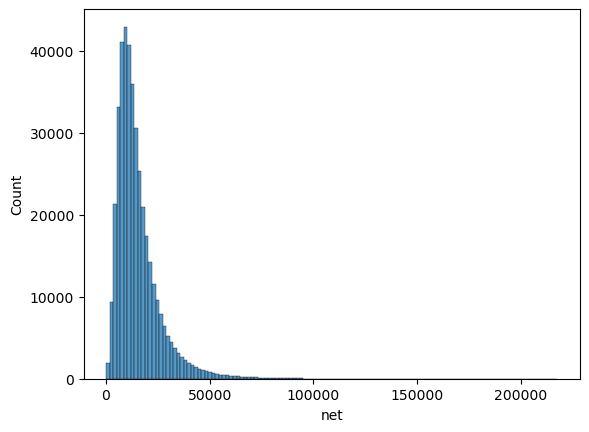

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(
    data=data_2020Q1[~defaulted_loan_ids],
    x="net",
    bins=128,
    legend="net"
)

plt.plot()

In [10]:
default_rate = defaulted_loan_ids.mean()

default_rate

np.float64(0.0021905966428860863)

In [27]:
def simulate_portfolio(
    data: pd.DataFrame,
    defaulted: pd.Series,
    default_rate: float = None,
    N=10000,
    n=100
) -> np.ndarray:
    if default_rate is None:
        default_rate = defaulted.mean()

    n_paid = int(n * (1 - default_rate))
    n_defaulted = int(n * default_rate)

    investment_paid = data["orig_upb"][~defaulted].values
    investment_defaulted = data["orig_upb"][defaulted].values

    net_paid = data["net"][~defaulted].values
    net_defaulted = data["net"][defaulted].values

    index_paid = np.random.randint(0, len(net_paid), size=(N, n_paid))
    index_defaulted = np.random.randint(0, len(net_defaulted), size=(N, n_defaulted))

    investment = np.take(investment_paid, index_paid).sum(axis=1) + \
        np.take(investment_defaulted, index_defaulted).sum(axis=1)
    net = np.take(net_paid, index_paid).sum(axis=1) + \
        np.take(net_defaulted, index_defaulted).sum(axis=1)

    return net / investment, net

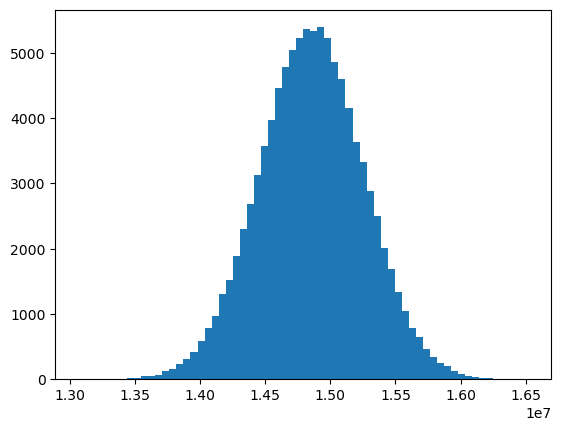

In [29]:
returns, net = simulate_portfolio(
    data_2020Q1,
    defaulted_loan_ids,
    N=100_000,
    n=1_000
)

plt.hist(
    net,
    bins=64
)
plt.show()